In [10]:
import rasterio as rio
import numpy as np
import os
from rasterio.plot import show, show_hist # some specific rasterio functions we'll need
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
os.chdir('/Users/najah/work/internships/meghna/')

In [31]:
# lading bands 

image_file = './wajida_files/Layerstack.tif'

l5= rio.open(image_file)

In [36]:
l5.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 7931,
 'height': 7001,
 'count': 6,
 'crs': CRS.from_epsg(32644),
 'transform': Affine(30.0, 0.0, 356085.0,
        0.0, -30.0, 2500515.0)}

In [33]:
random_points = gpd.read_file('./wajida_files/points/500.shp')



In [34]:
random_points = random_points.to_crs({'init': 'epsg:32644'})

/Users/najah/miniforge3/envs/ee/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


<AxesSubplot:>

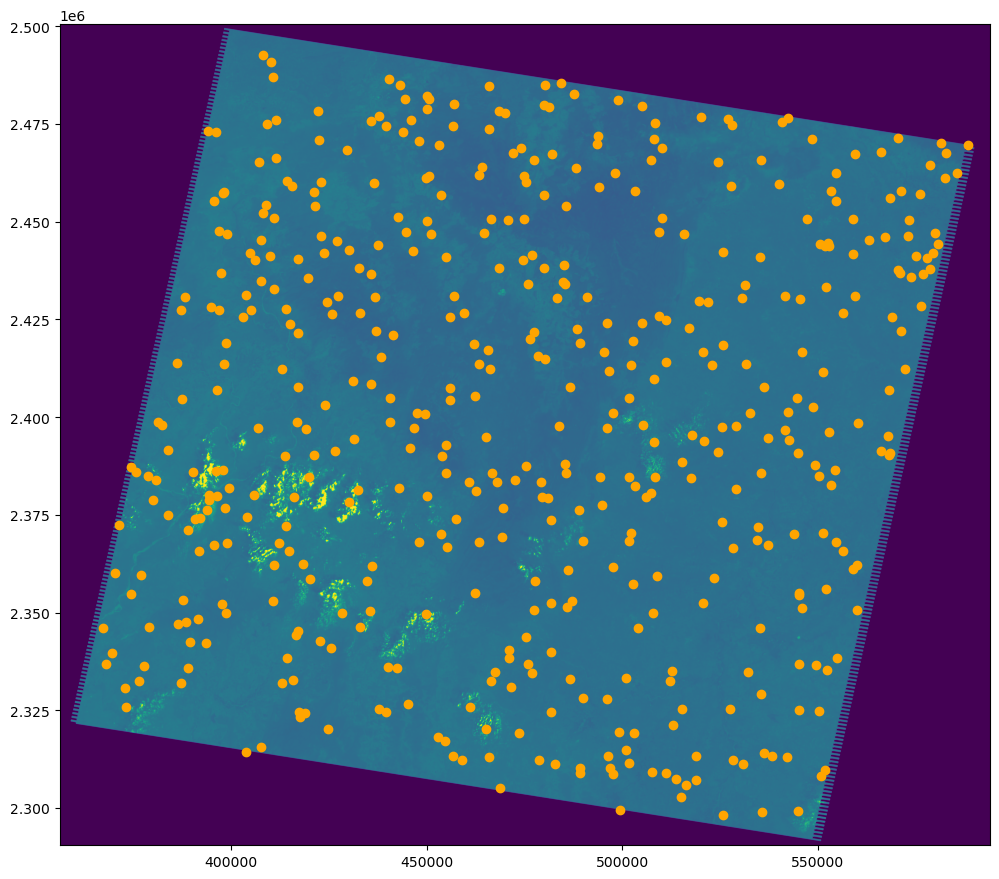

In [35]:
fig, ax = plt.subplots(figsize = (12,12))
random_points.plot(ax = ax, color = 'orange')
show((l5,1), ax = ax)

In [37]:
# reading alll the bands to a dictionary
bands_dict = {}

with rio.open (image_file) as src:
    for bands in range (1,7):
        bands_dict[ str('b')+ str(bands) ] = src.read(bands)

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


In [38]:
# renaming the b6 to b7 since there's no thermal bands
bands_dict['b7'] = bands_dict['b6']

In [39]:
del bands_dict ['b6']

In [42]:
bands_dict.keys()

dict_keys(['b1', 'b2', 'b3', 'b4', 'b5', 'b7'])

In [7]:
## reading thermal band

# thermal = rio.open('./145044_20100428_B6_caliberated_masked.tif')
# b6 = thermal.read(1)



In [8]:
# bands_dict['b6'] = b6

In [7]:
## reading mask file

mask_file = rio.open('./145044_20100428_mask_all.tif')
mask = mask_file.read(1)
bands_dict['mask'] = mask

In [8]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [43]:
# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [44]:
# normalizedDifference function

# how do i document a function?

def normalizedDifference(indice,df,b1,b2):
    df[indice] = (df[b1].astype(float)-df[b2].astype(float))/(df[b1]+df[b2])  
    print( indice + " " + 'created successfully')

In [45]:
# add equation
normalizedDifference('ndvi', bands_dict,'b4', 'b3')

ndvi created successfully


In [46]:
## ndmi
# add  equation
normalizedDifference('ndmi',bands_dict,'b4', 'b5')

ndmi created successfully


In [47]:
##nbr
# add equation
normalizedDifference('nbr',bands_dict,'b4', 'b7')

nbr created successfully


In [48]:
# NDWI = (G-NIR)/(G+NIR)

normalizedDifference('ndwi',bands_dict,'b2', 'b4')

ndwi created successfully


In [49]:
### BAI
# `BAI = 1/((0.1 -RED)^2 + (0.06 - NIR)^2)`

bands_dict['bai'] = 1/((0.1 - bands_dict["b3"].astype(float))**2 + (0.06 - bands_dict['b4'].astype(float))**2)

In [15]:
bands_dict['bai'][mask==0]= np.nan

In [16]:
np.nanmax(bands_dict['bai'])

1220539.0063720166

In [17]:
np.sum(bands_dict['bai']>1200000)

139

In [50]:
### baiml

#`1/((B4- (.5*B4))^2+ (B7-(.2*B7))^2)`



bands_dict['baiml'] = 1/((bands_dict['b4']- (.5*bands_dict['b4']))**2+ (bands_dict['b7']-(.2*bands_dict['b7']))**2)

In [19]:
bands_dict['baiml'][mask==0]= np.nan

In [51]:
### baims
#`1/((B4- (.5*B4))^2+ (B5-(.2*B5))^2)`

bands_dict['baims'] = 1/((bands_dict['b4']- (.5*bands_dict['b4']))**2+ (bands_dict['b5']-(.2*bands_dict['b5']))**2)

In [21]:
bands_dict['baims'][mask==0]= np.nan

In [52]:
### MiRBi

#(10*B7) - ((9.8 * B5) +2)


bands_dict['mirbi'] = (10 * bands_dict['b7']) - ((9.8 * bands_dict['b5']) + 2)

In [23]:
bands_dict['mirbi'][mask==0]= np.nan

In [27]:
### NBRT
#(B4-B7*(B6/1000))/(B4+B7*(B6/1000))

In [28]:
#bands_dict['nbrt'] = (bands_dict['b4']-bands_dict['b7']*(bands_dict['b6']/1000))/(bands_dict['b4']+bands_dict['b7']*(bands_dict['b6']/1000))

## there seems to be an issue with masking - needs to be solved

In [54]:
#`GEMI = eta*(1-.25*eta)-((B3-.125)/(1-B3))`

#where eta is 

#`eta = 2*(B4^2-B3^2)+ (1.5*B4)+(.5*B3))/(B4+B3+.5)`


eta = (2*(bands_dict['b4']**2-bands_dict['b3']**2)+ (1.5*bands_dict['b4'])+(.5*bands_dict['b3']))/(bands_dict['b4']+bands_dict['b3']+.5)

bands_dict['gemi'] = eta*(1-.25*eta)-((bands_dict['b3']-.125)/(1-bands_dict['b3']))

#bands_dict['gemi'][mask==0]= np.nan


In [34]:
### saving

In [55]:
# Set spatial characteristics of the output object to mirror the input
kwargs = src.meta
kwargs.update(
    dtype=rio.float32,
    count = 1)

## saving the file

indices_list = ['ndvi', 'ndmi', 'nbr', 'ndwi','bai', 'baims', 'baiml', 'mirbi', 'gemi']
for i in indices_list:
    with rio.open('./wajida_files/python/143045_20100329_' + f'{i}' + ".tif", 'w', **kwargs) as dst: 
        dst.write_band(1, bands_dict[i].astype(rio.float32))
        print (i)

ndvi
ndmi
nbr
ndwi
bai
baims
baiml
mirbi
gemi


In [ ]:
#rio.plot.show_hist(bands_dict['bai'][bands_dict['bai']<89],  histtype='stepfilled', lw=0.0, stacked=False, alpha=0.3)

In [47]:
# # Set spatial characteristics of the output object to mirror the input
# kwargs = src.meta
# kwargs.update(
#     dtype=rio.float32,
#     count = 1)

# # Create the file
# with rio.open('./145044_20100428_indices/python/145044_20100428_baiml.tif', 'w', **kwargs) as dst:
#         dst.write_band(1, bands_dict['baiml'].astype(rio.float32))

## Viz

In [28]:
# how do save it as a png?

import matplotlib.pyplot as plt
plt.imsave("./145044_20100428_indices/python/images/145044_20100428_ndvi_cmap.jpg",bands_dict['ndvi'], cmap=plt.cm.summer)

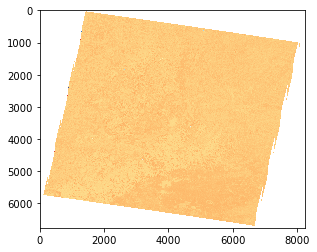

In [170]:
plt.imshow(bands_dict['mirbi'],
           interpolation='nearest',
            cmap="RdYlBu")
plt.show()

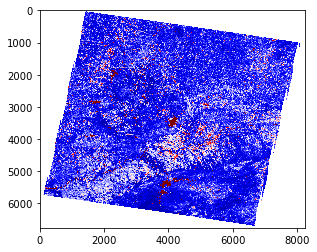

In [165]:
plt.imshow(bands_dict['baims'],
           interpolation='nearest',
            cmap="seismic",
          vmin=0, vmax=89)
plt.show()

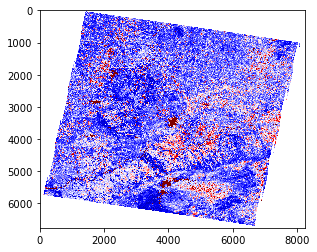

In [164]:
plt.imshow(bands_dict['baiml'],
           interpolation='nearest',
            cmap="seismic",
          vmin=0, vmax=89)
plt.show()

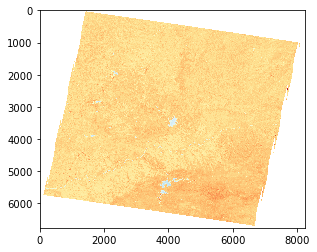

In [29]:
plt.imshow(bands_dict['ndwi'],
           interpolation='nearest',
            cmap="RdYlBu")
plt.show()

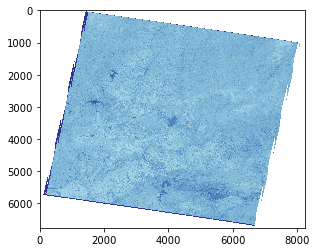

In [159]:
plt.imshow(bands_dict['nbrt'],
           interpolation='nearest',
            cmap="RdYlBu")
plt.show()

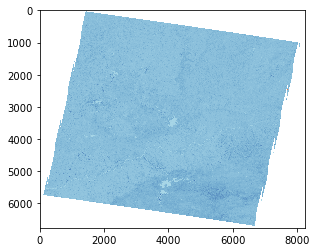

In [160]:
plt.imshow(bands_dict['gemi'],
           interpolation='nearest',
            cmap="RdYlBu")
plt.show()

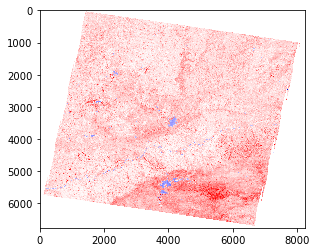

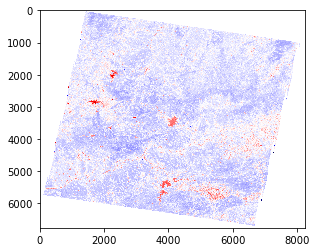

In [119]:
indices_list = ['ndvi', 'ndmi']
for indice in indices_list:
    plt.imshow(bands_dict[indice],
           interpolation='nearest',
           cmap='seismic')
    plt.show()


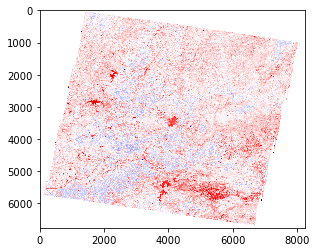

In [167]:
plt.imshow(bands_dict['nbr'],
           interpolation='nearest',
            cmap="seismic")
plt.show()